# FORGE: Pre-training Open Foundation Model for Science

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib.cm as cmx
import matplotlib as mpl
import glob,os 
import pandas as pd
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib
%matplotlib inline

mpl.rc('lines', linewidth=2)
mpl.rc('axes', labelsize=16, titlesize=16)
mpl.rc('figure', titlesize=20)
mpl.rc('font', size=14)  # global font size
mpl.rc('legend', fontsize=14, fancybox=True)
mpl.rc('xtick.major', size=6)
mpl.rc('xtick.minor', size=4)
mpl.rcParams['font.size'] = 14.0


labels = {'Mat':0,
          'Phy':1,
          'Che':2,
          'Eng':3,
          'Bio':4,
          'Soc':5
          }
'''
labels = {'BCC':0,
          'FCC':1,
          'HCP':2,
          'Multi':3,
          }
'''


def set_tick_font_size(axes, font_size):
    def __set_axis_tick(axis):
        for tick in axis.xaxis.get_major_ticks():
            tick.label.set_fontsize(font_size)
        for tick in axis.yaxis.get_major_ticks():
            tick.label.set_fontsize(font_size)
    if hasattr(axes, '__iter__'):
        for axis in axes:
            __set_axis_tick(axis)
    else:
        __set_axis_tick(axes)
        
        
def tsne_plot(x_pred_encoded, y_train, plot_name, clabel="Temperature"):
    Dmax = y_train;
    [n,s] = np.histogram(Dmax, 11);
    d = np.digitize(Dmax, s);
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    #set_tick_font_size(ax, 16)
    ax.tick_params(axis='both', length=0)
     # remove labels under x-axis
    ax.set_xticklabels([])

    # remove labels left of y-axis
    ax.set_yticklabels([])   
    
    ax.set_title("Domain Classification", fontsize=24)
   
    cmi = plt.get_cmap('jet');
    cNorm = mpl.colors.Normalize(vmin=min(Dmax), vmax=max(Dmax));
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmi);

    x = x_pred_encoded[:,0]
    y = x_pred_encoded[:,1]

    ax.scatter(x, y, c=scalarMap.to_rgba(Dmax), marker="o", s=1, alpha=0.5)
    #ax.set_xlabel("$t_1$", fontsize=18)
    #ax.set_ylabel("$t_2$", fontsize=18)
    scalarMap.set_array(Dmax);
    cbar = plt.colorbar(scalarMap, location='bottom', pad=0.02);
    cbar.set_ticks(list(labels.values()))
    cbar.set_ticklabels(list(labels.keys()))
    cbar.ax.tick_params(labelsize=24)   
    
    plt.savefig(plot_name, format='png',dpi=300, bbox_inches='tight');
    plt.show()
    plt.clf();
        

In [19]:
from glob import glob 
def read_fsdplog(datadir='gpt13b-n1/summit', model='GPT13B', n=1, prec='fp16', sys="Summit"):
    fname = glob("{}/{}_fsdp_{}_*_{}.txt".format(datadir,sys,model,prec))[0]
    print(fname)
    with open(fname, 'r') as f:
        for line in f:
            if re.search("tflops", line):
                rtime = float(line.split(" ")[2])
            if re.search("max mem", line):
                mem = float(line.split(" ")[3].split("G")[0])
    return rtime, mem

def read_stats(datadir='gpt13b-n1-offload', sys='summit', model='GPT13B', gpuid=0):
    fname = glob("{}/log.*.{}.*".format(datadir,model))[0]
    print(fname)
    pwr, mem, util = {}, {}, {}
    if sys == 'summit':
        first = False
        with open(fname, 'r') as f:
            for line in f:
                if re.search("%d, gpuUtil"%gpuid, line):
                    k, v = int(line.split(",")[-2]),float(line.split(",")[-1])
                    if not first: 
                        k0 = k 
                        first = True
                    util[(k-k0)//1e6] = v              
                if re.search("%d, pwrDraw"%gpuid, line):
                    k, v = int(line.split(",")[-2]),float(line.split(",")[-1])
                    if not first: 
                        k0 = k 
                        first = True
                    pwr[(k-k0)//1e6] = v
                if re.search("%d, memUtil"%gpuid, line):
                    k, v = int(line.split(",")[-2]),float(line.split(",")[-1])
                    if not first: 
                        k0 = k 
                        first = True
                    mem[(k-k0)//1e6] = v
    else:
        df = pd.read_csv(fname, header=None)
        pwr = df.iloc[gpuid::8, 0].astype(float).reset_index(drop=True).to_dict()
        mem = df.iloc[gpuid::8, 3].astype(float).reset_index(drop=True).to_dict()
        util = df.iloc[gpuid::8, 1].astype(float).reset_index(drop=True).to_dict()
                
    return pwr, mem, util



def measure(pwr, tmin=1000, tmax=1500):
    ps=[]
    for t,p in pwr.items():
        if t >=tmin and t <=tmax:
            ps.append(p)
    ps = np.array(ps, dtype=float)
    return ps.mean(), ps.std()


#read_stats(datadir='gpt175b-n4-offload', sys='crusher', model='GPT175B')[0]

In [50]:
import json

def read_eval(datadir, tasks, bs=16):
    files = glob("{}/eval_results_*".format(datadir))
    results = {}
    for file in files:
        step = int(file.split('.')[0].split('p')[1])
        token = step*bs
        with open(file) as f:
            data = json.load(f)
        output= []
        for task in tasks:
            acc = data['results'][task]['acc']
            output.append(acc)
        results[token] = output 
    return results

print(read_eval('data/eval/forge-s4', ['sciq', 'piqa', 'openbookqa', 'arc_challenge', 'arc_easy']))


{176000: [0.852, 0.6256800870511425, 0.188, 0.24658703071672355, 0.5643939393939394], 192000: [0.856, 0.6235038084874864, 0.202, 0.2508532423208191, 0.5787037037037037], 20000: [0.436, 0.5342763873775843, 0.144, 0.2030716723549488, 0.27441077441077444], 208000: [0.856, 0.6235038084874864, 0.198, 0.25, 0.5707070707070707], 240000: [0.861, 0.6245919477693145, 0.2, 0.25597269624573377, 0.5782828282828283], 30000: [0.472, 0.5418933623503809, 0.14, 0.2150170648464164, 0.26430976430976433], 64000: [0.824, 0.5897714907508161, 0.156, 0.21245733788395904, 0.49747474747474746], 80000: [0.833, 0.5903155603917302, 0.172, 0.21331058020477817, 0.5298821548821548], 10000: [0.47, 0.5255712731229597, 0.178, 0.20051194539249148, 0.2689393939393939], 112000: [0.836, 0.6131664853101197, 0.164, 0.23208191126279865, 0.5420875420875421], 128000: [0.856, 0.6196953210010882, 0.196, 0.24061433447098976, 0.553030303030303], 144000: [0.847, 0.6164309031556039, 0.202, 0.23720136518771331, 0.5635521885521886]}


In [1]:
import re
from typing import Dict

def read_rccltests(filename):
    pattern = r".*float.*"
    data = {'size': [], 'busbw': []}
    with open(filename, 'r') as f:
        for line in f:
            matches = re.findall(pattern, line)
            
            if matches:
                size, busbw = matches[0].split()[0],matches[0].split()[6] 
                data['size'].append(int(size)/1024**2)
                data['busbw'].append(float(busbw))
    return data


#read_rccltests('data/msg/log.all_reduce.n1.1292356')

In [76]:
import re

def read_perf(datadir):
    file = glob("{}/neox.o*".format(datadir))[0]
    with open(file, "r") as f:
        data = f.read()
    pattern = r"approx flops per GPU: (\d+\.\d+)TFLOPS"
    tflops = re.findall(pattern, data)[1:5]
    mean_tflops = sum(map(float, tflops)) / len(tflops)
    return mean_tflops

read_perf("data/perf/forge-s/n1-ssd")
read_perf("data/perf/forge-m/n1")

63.825

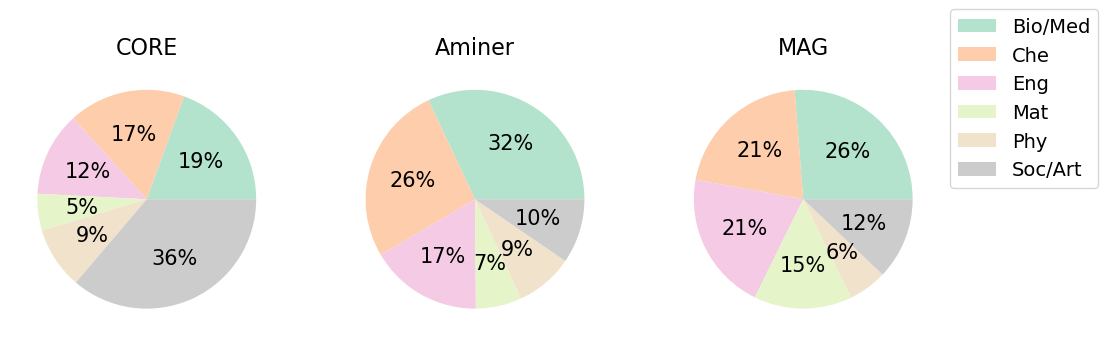

In [6]:
labels = ['Bio/Med', 'Che', 'Eng', 'Mat', 'Phy', 'Soc/Art']

df = pd.read_csv('data/preprocess/partitions.csv', header=0, delim_whitespace=True)
core, aminer, mag = df['core'], df['aminer'], df['mag']

core_pct  = [ 1.0*n/sum(core) for n in core]
aminer_pct  = [ 1.0*n/sum(aminer) for n in aminer]
mag_pct  = [ 1.0*n/sum(mag) for n in mag]

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

cmap = plt.cm.Pastel2
colors = cmap(np.linspace(0., 1., len(labels)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# create the pie charts
ax1.pie(core_pct,  autopct='%1.f%%', colors=colors,textprops={'fontsize': 15})
ax2.pie(aminer_pct,  autopct='%1.f%%', colors=colors,textprops={'fontsize': 15})
ax3.pie(mag_pct,  autopct='%1.f%%', colors=colors,textprops={'fontsize': 15})

# set the titles of the subplots
ax1.set_title('CORE')
ax2.set_title('Aminer')
ax3.set_title('MAG')

# create the legend separately
fig.legend(labels=labels, loc='lower left', bbox_to_anchor=(0.9, 0.5))

plt.savefig('domains.png', dpi=300, bbox_inches='tight')

embedded shape: (5994, 768)
label shape: (5994,)


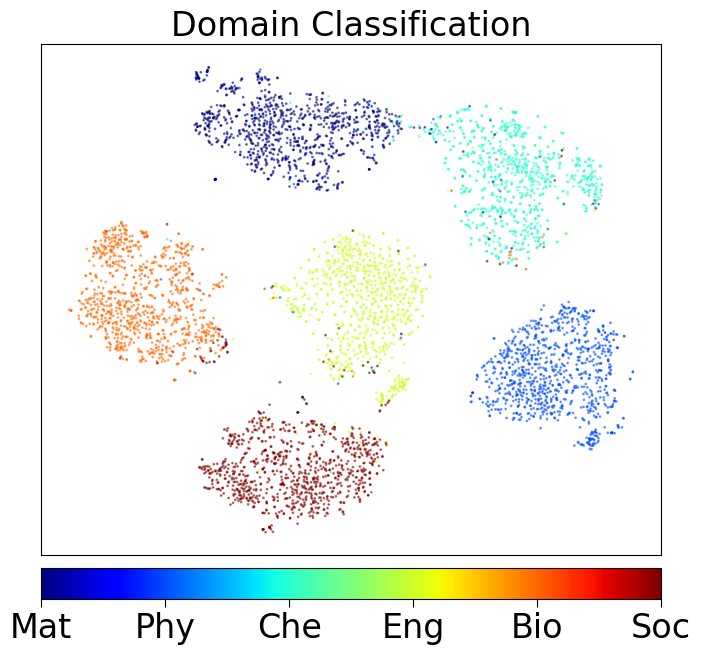

<Figure size 640x480 with 0 Axes>

In [147]:
emb_file = "data/domain/emb_scibert_scivocab_uncased_classifier.npz"
X = np.load(emb_file, allow_pickle=True)['embedding']
X = np.array(list(X), dtype=float)
X = np.squeeze(X)
print("embedded shape:", X.shape)

label = np.load(emb_file, allow_pickle=True)['label']
print("label shape:", label.shape)

X_embedded = np.load("data/domain/encoded_TSNE_2D.npy")
tsne_plot(X_embedded, label, 'embedding_cluster.png')


embedded shape: (1252, 5)
label shape: (1252,)


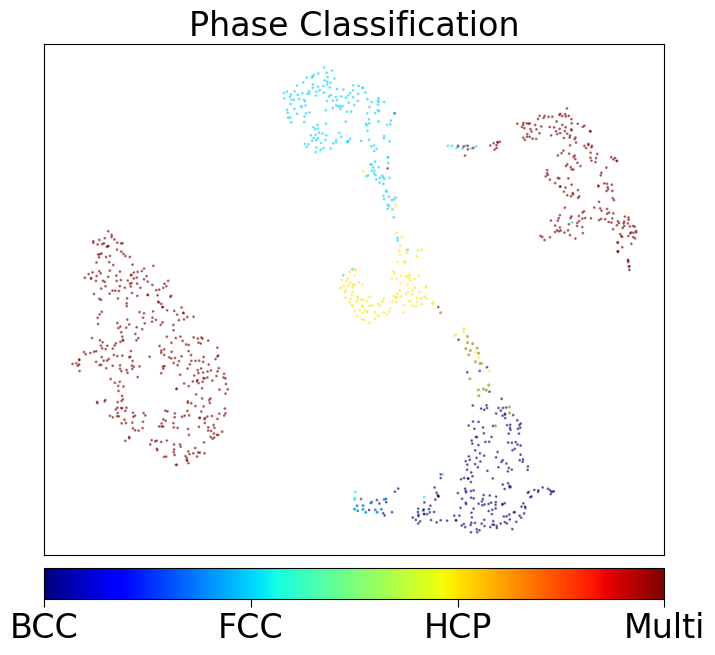

<Figure size 640x480 with 0 Axes>

In [145]:
emb_file = "data/phase/emb_fept_matscibert_classifier.pt.npz"
X = np.load(emb_file, allow_pickle=True)['embedding']
X = np.array(list(X), dtype=float)
X = np.squeeze(X)
print("embedded shape:", X.shape)

label = np.load(emb_file, allow_pickle=True)['label']
print("label shape:", label.shape)

X_embedded = np.load("data/phase/encoded_TSNE_2D.npy")
tsne_plot(X_embedded, label, "alloy_phases_cluster.png")


{'Orion': [60.125, 59.125, 57.150000000000006], 'SSD': [60.65, 60.599999999999994, 60.175]}
      Orion     SSD
128  60.125  60.650
256  59.125  60.600
512  57.150  60.175


<Figure size 600x600 with 0 Axes>

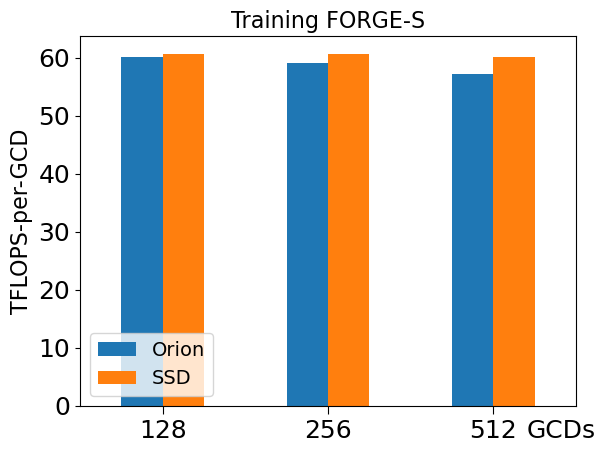

In [79]:

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(6,6))


n1ssd = read_perf("data/perf/forge-s/n1-ssd")
n1sfs = read_perf("data/perf/forge-s/n1-orion")

n16ssd = read_perf("data/perf/forge-s/n16-ssd")
n16sfs = read_perf("data/perf/forge-s/n16-orion")

n32ssd = read_perf("data/perf/forge-s/n32-ssd")
n32sfs = read_perf("data/perf/forge-s/n32-orion")

n64ssd = read_perf("data/perf/forge-s/n64-ssd")
n64sfs = read_perf("data/perf/forge-s/n64-orion")

m_n1 = read_perf("data/perf/forge-m/n1")
m_n16 = read_perf("data/perf/forge-m/n16")
m_n32 = read_perf("data/perf/forge-m/n32")
m_n64ssd = read_perf("data/perf/forge-m/n64-ssd")
m_n64orion = read_perf("data/perf/forge-m/n64-orion")

l_n16 = read_perf("data/perf/forge-l/n16")
l_n32 = read_perf("data/perf/forge-l/n32")
l_n64ssd = read_perf("data/perf/forge-l/n64-ssd")
l_n64orion = read_perf("data/perf/forge-l/n64-orion")
    
data = {
        "Orion" : [n16sfs, n32sfs, n64sfs],
        "SSD" : [n16ssd, n32ssd, n64ssd]
}
print(data)

df = pd.DataFrame(data, columns=['Orion', 'SSD'], index = ['128','256', '512'])

ax = df.plot.bar()
#ax.set_xticks(df.index)
ax.set_xticklabels(df.index, rotation=0)

plt.title("Training FORGE-S")
#plt.xlabel('#GCDs')
plt.text(2.2,-5.5, "GCDs")
plt.ylabel('TFLOPS-per-GCD')
plt.legend(loc='lower left')

plt.savefig('io1.png', dpi=300, bbox_inches='tight')

{'Orion': [57.150000000000006, 45.05, 46.949999999999996], 'SSD': [60.175, 45.699999999999996, 47.900000000000006]}
         Orion     SSD
FORGE-S  57.15  60.175
FORGE-M  45.05  45.700
FORGE-L  46.95  47.900


<Figure size 600x600 with 0 Axes>

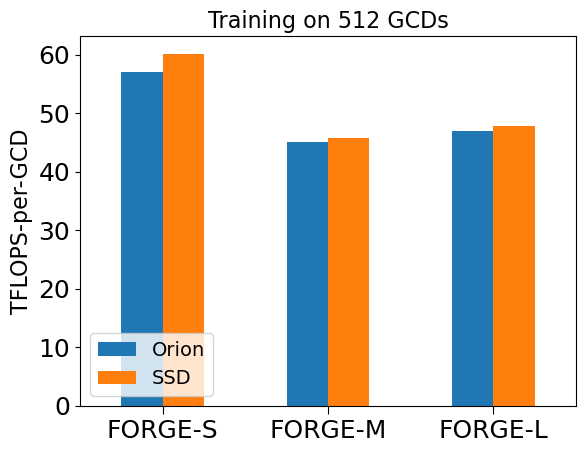

In [80]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(6,6))

    
data = {
        "Orion" : [n64sfs, m_n64orion, l_n64orion],
        "SSD" : [n64ssd, m_n64ssd, l_n64ssd]
}
print(data)

df = pd.DataFrame(data, columns=['Orion', 'SSD'], index = ['FORGE-S','FORGE-M', 'FORGE-L'])

ax = df.plot.bar()
#ax.set_xticks(df.index)
ax.set_xticklabels(df.index, rotation=0)

plt.title("Training on 512 GCDs")
#plt.ylabel('#GCDs')
plt.ylabel('TFLOPS-per-GCD')
plt.legend(loc='lower left')

plt.savefig('io2.png', dpi=300, bbox_inches='tight')


0.9799599198396793 0.9823399558498896 0.9392033542976939 0.9401197604790419


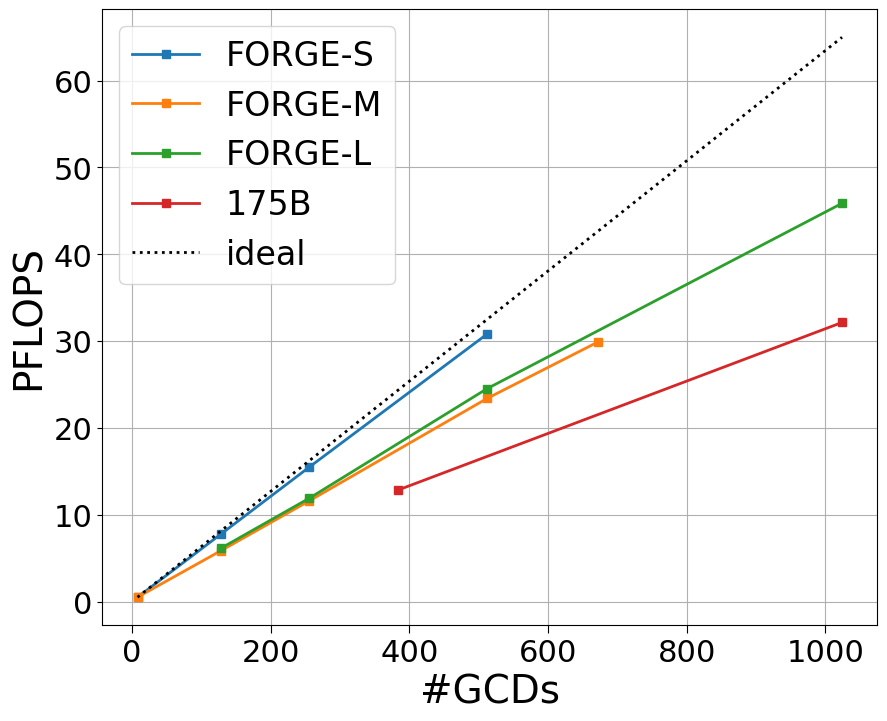

In [206]:
#scaling

s = {8:n1ssd, 128:n16ssd, 256:n32ssd, 512:n64ssd}
m = {8:m_n1, 128:m_n16, 256:m_n32, 512:m_n64ssd, 672:44.5}
l = {128:l_n16, 256:l_n32, 512:l_n64ssd, 1024:44.8}
g = {384:33.5, 1024:31.4}


ideal = [8,128,256,512,1024]

print(48.9/49.9 , 44.5/45.3, 44.8/47.7, 31.4/33.4)

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 28,
        }

fig, ax = plt.subplots(figsize=(10, 8))

#ax.set_ylim((400,600))
set_tick_font_size(ax, 22)

ax.plot(s.keys(), np.array([n*v for n,v in s.items()])/1000, marker='s', label='FORGE-S')
ax.plot(m.keys(), np.array([n*v for n,v in m.items()])/1000, marker='s', label='FORGE-M')
ax.plot(l.keys(), np.array([n*v for n,v in l.items()])/1000, marker='s', label='FORGE-L')
ax.plot(g.keys(), np.array([n*v for n,v in g.items()])/1000, marker='s', label='175B')
ax.plot(ideal, np.array([n*next(iter(s.items()))[1] for n in ideal])/1000, linestyle='dotted', color='k', label='ideal')

ax.grid()
#ax.set_title("Weak scaling",fontdict=font)
ax.set_ylabel('PFLOPS', fontdict=font)
ax.set_xlabel('#GCDs', fontdict=font)
#ax.set_xscale('log')

ax.legend(fontsize=24)
plt.savefig('scale1.png', dpi=300, bbox_inches='tight')


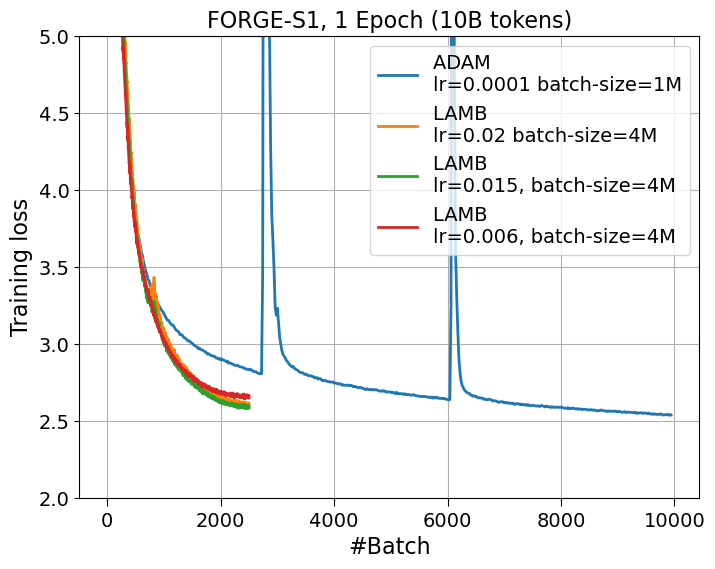

In [27]:
#1-3b-aminer-lamb

lr0_02 = pd.read_csv("data/lamb/aminer/lr0.02.csv").iloc[:,1:]
lr0_015 = pd.read_csv("data/lamb/aminer/lr0.015.csv").iloc[:,1:]
lr0_01 = pd.read_csv("data/lamb/aminer/lr0.01.csv").iloc[:,1:]
lr0_006 = pd.read_csv("data/lamb/aminer/lr0.006.csv").iloc[:,1:]
baseline = pd.read_csv("data/lamb/aminer/baseline.csv", header=None, names=['Step', 'Value']).iloc[:510, :]


font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_ylim((2,5))

ax.plot(baseline['Step'], baseline['Value'], label='ADAM \nlr=0.0001 batch-size=1M')

ax.plot(lr0_02['Step'], lr0_02['Value'],label='LAMB \nlr=0.02 batch-size=4M')
ax.plot(lr0_015['Step'], lr0_015['Value'], label='LAMB \nlr=0.015, batch-size=4M')
ax.plot(lr0_006['Step'], lr0_006['Value'], label='LAMB \nlr=0.006, batch-size=4M')

ax.grid()
ax.set_title("FORGE-S1, 1 Epoch (10B tokens)",fontdict=font)
ax.set_ylabel('Training loss', fontdict=font)
ax.set_xlabel('#Batch', fontdict=font)

ax.legend()
plt.savefig('lamb1.png', dpi=300, bbox_inches='tight')

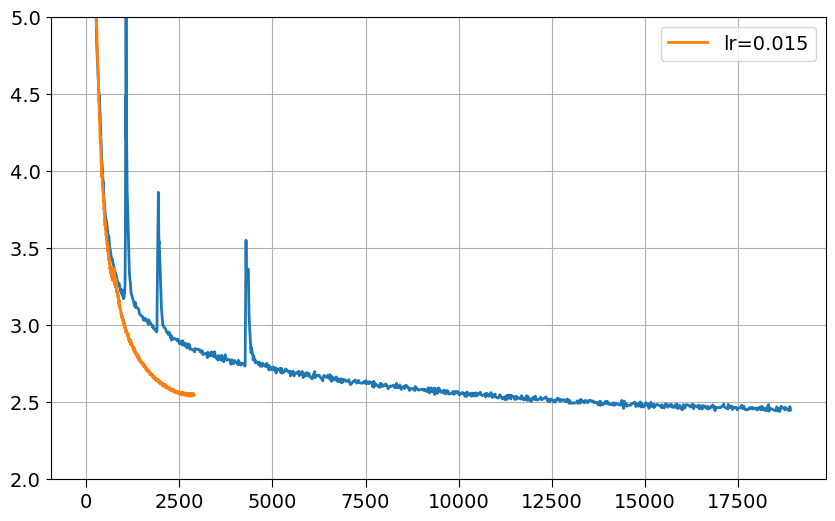

In [74]:
lr0_015 = pd.read_csv("data/lamb/mag/lr0.015.csv").iloc[:,1:]

baseline = pd.read_csv("data/lamb/mag/baseline.csv").iloc[:,1:]


font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_ylim((2,5))

ax.plot(baseline['Step'], baseline['Value'])

ax.plot(lr0_015['Step'], lr0_015['Value'], label='lr=0.015')
ax.grid()


ax.legend()

2.255711793899536


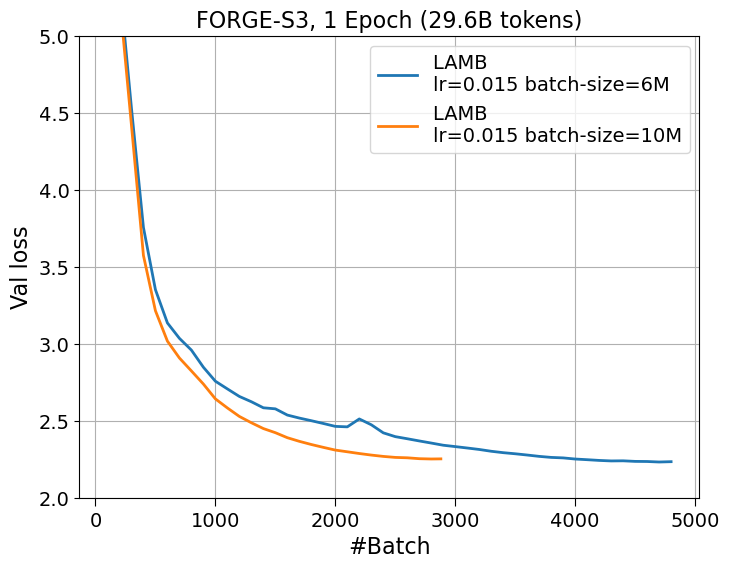

In [26]:

bs6m = pd.read_csv("data/lamb/aminer-mag/val/6M.csv").iloc[:,1:]
bs10m = pd.read_csv("data/lamb/aminer-mag/val/10M.csv").iloc[:,1:]

print(bs10m.iloc[-1,-1])

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_ylim((2,5))


ax.plot(bs6m['Step'], bs6m['Value'],label='LAMB \nlr=0.015 batch-size=6M')
ax.plot(bs10m['Step'], bs10m['Value'],label='LAMB \nlr=0.015 batch-size=10M')
ax.grid()
ax.set_title("FORGE-S3, 1 Epoch (29.6B tokens)",fontdict=font)
ax.set_ylabel('Val loss', fontdict=font)
ax.set_xlabel('#Batch', fontdict=font)

ax.legend()
plt.savefig('lamb2.png', dpi=300, bbox_inches='tight')

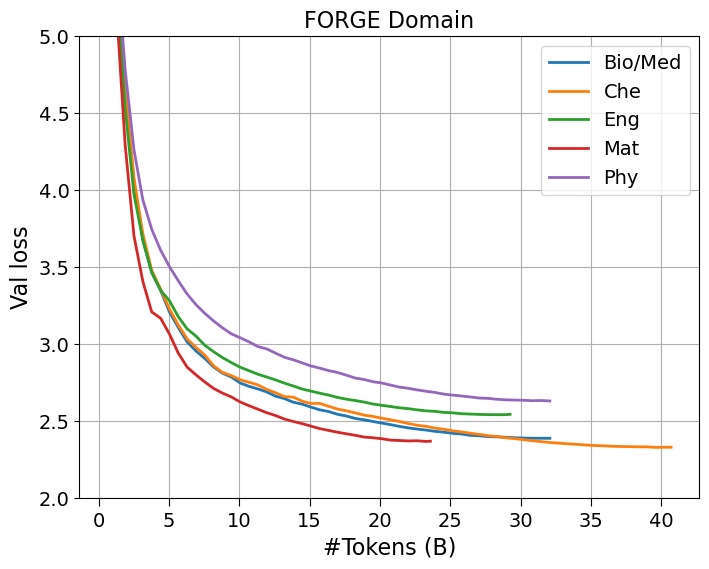

In [237]:
#domain 


bio = pd.read_csv("data/loss/med.csv").iloc[:,1:]
che = pd.read_csv("data/loss/che.csv").iloc[:,1:]
eng = pd.read_csv("data/loss/cs.csv").iloc[:,1:]
mat = pd.read_csv("data/loss/mat.csv").iloc[:,1:]
phy = pd.read_csv("data/loss/phy.csv").iloc[:,1:]

bs = 6291456

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_ylim((2,5))


ax.plot(bio['Step']*6291456/10**9, bio['Value'],label='Bio/Med')
ax.plot(che['Step']*6291456/10**9, che['Value'],label='Che')
ax.plot(eng['Step']*6291456/10**9, eng['Value'],label='Eng')
ax.plot(mat['Step']*6291456/10**9, mat['Value'],label='Mat')
ax.plot(phy['Step']*6291456/10**9, phy['Value'],label='Phy')
ax.grid()
ax.set_title("FORGE Domain",fontdict=font)
ax.set_ylabel('Val loss', fontdict=font)
ax.set_xlabel('#Tokens (B)', fontdict=font)

ax.legend()
plt.savefig('loss-domain.png', dpi=300, bbox_inches='tight')

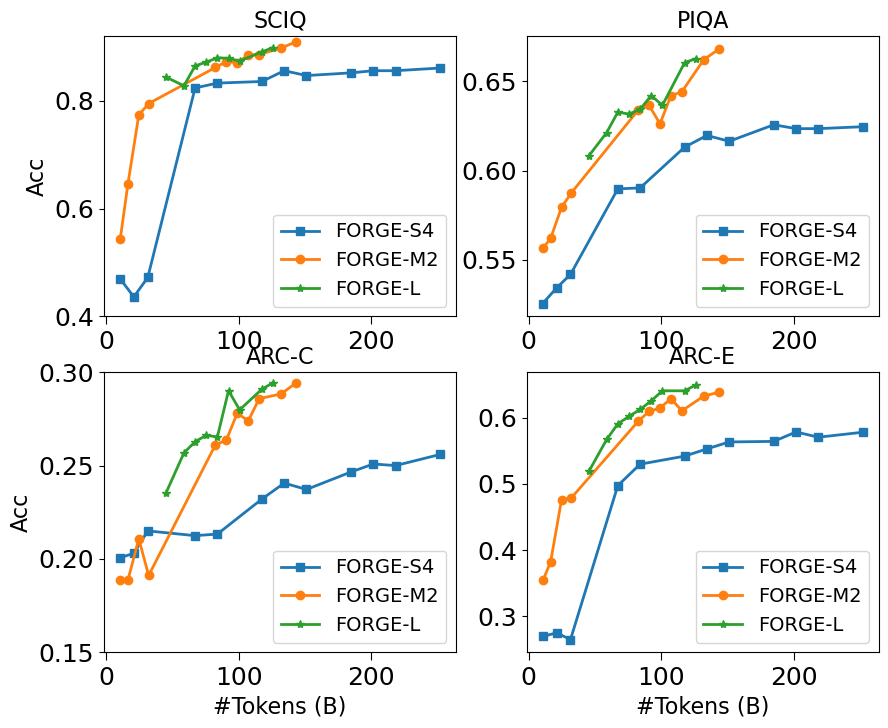

In [90]:
#acc vs tokens

labels = ['SCIQ', 'PIQA', 'OBQA', 'ARC-C', 'ARC-E']
s4  = read_eval('data/eval/forge-s4', ['sciq', 'piqa', 'openbookqa', 'arc_challenge', 'arc_easy'], bs=16.8)
s4  = dict(sorted(s4.items()))

m2  = read_eval('data/eval/forge-m2', ['sciq', 'piqa', 'openbookqa', 'arc_challenge', 'arc_easy'], bs=16.5)
m2  = dict(sorted(m2.items()))

l  = read_eval('data/eval/forge-l', ['sciq', 'piqa', 'openbookqa', 'arc_challenge', 'arc_easy'], bs=16.8)
l  = dict(sorted(l.items()))

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, axs = plt.subplots(2,2, figsize=(10, 8))

xs = np.array(list(s4.keys()))/1000
ys = s4.values()

xm = np.array(list(m2.keys()))/1000
ym = m2.values()

xl = np.array(list(l.keys()))/1000
yl = l.values()

# Plot the data on each subplot
axs[0, 0].plot(xs, [v[0] for v in ys], marker='s', label='FORGE-S4')
axs[0, 0].plot(xm, [v[0] for v in ym], marker='o', label='FORGE-M2')
axs[0, 0].plot(xl, [v[0] for v in yl], marker='*', label='FORGE-L')
axs[0, 0].set_ylabel('Acc', fontdict=font)
axs[0, 0].set_ylim([0.4,0.92])
axs[0, 0].legend(loc='lower right')
axs[0, 0].set_title(labels[0])
axs[0, 1].plot(xs, [v[1] for v in ys], marker='s', label='FORGE-S4')
axs[0, 1].plot(xm, [v[1] for v in ym], marker='o', label='FORGE-M2')
axs[0, 1].plot(xl, [v[1] for v in yl], marker='*', label='FORGE-L')
axs[0, 1].legend(loc='lower right')
axs[0, 1].set_title(labels[1])
axs[1, 0].plot(xs, [v[3] for v in ys], marker='s', label='FORGE-S4')
axs[1, 0].plot(xm, [v[3] for v in ym], marker='o', label='FORGE-M2')
axs[1, 0].plot(xl, [v[3] for v in yl], marker='*', label='FORGE-L')
axs[1, 0].set_ylabel('Acc', fontdict=font)
axs[1, 0].set_xlabel('#Tokens (B)', fontdict=font)
axs[1, 0].set_ylim([0.15,0.3])
axs[1, 0].legend(loc='lower right')
axs[1, 0].set_title(labels[3])
axs[1, 1].plot(xs, [v[4] for v in ys], marker='s', label='FORGE-S4')
axs[1, 1].plot(xm, [v[4] for v in ym], marker='o', label='FORGE-M2')
axs[1, 1].plot(xl, [v[4] for v in yl], marker='*', label='FORGE-L')
axs[1, 1].set_title(labels[4])
axs[1, 1].set_xlabel('#Tokens (B)', fontdict=font)
axs[1, 1].legend(loc='lower right')
# Set the title of the figure
#fig.suptitle('FORGE-S4')

fig.savefig('acc.png', dpi=300, bbox_inches='tight')


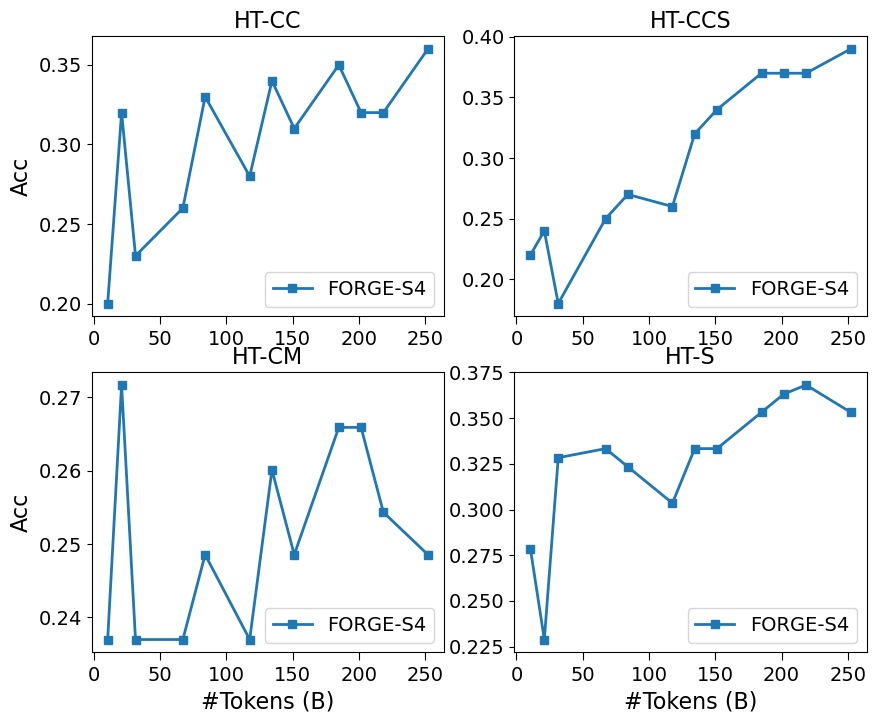

In [8]:
labels = ['HT-CC', 'HT-CCS', 'HT-CM', 'HT-S']#'HT-CP'
s4  = read_eval('data/eval/forge-s4', ['hendrycksTest-college_chemistry', 
                                       'hendrycksTest-college_computer_science', 
                                  #     'hendrycksTest-college_physics',
                                      'hendrycksTest-college_medicine',
                                      'hendrycksTest-sociology'], bs=16.8)
s4  = dict(sorted(s4.items()))
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, axs = plt.subplots(2,2, figsize=(10, 8))

xs = np.array(list(s4.keys()))/1000
ys = s4.values()


axs[0, 0].plot(xs, [v[0] for v in ys], marker='s', label='FORGE-S4')
axs[0, 0].set_ylabel('Acc', fontdict=font)
axs[0, 0].legend(loc='lower right')
axs[0, 0].set_title(labels[0])
axs[0, 1].plot(xs, [v[1] for v in ys], marker='s', label='FORGE-S4')
axs[0, 1].legend(loc='lower right')
axs[0, 1].set_title(labels[1])
axs[1, 0].plot(xs, [v[2] for v in ys], marker='s', label='FORGE-S4')
axs[1, 0].set_ylabel('Acc', fontdict=font)
axs[1, 0].set_xlabel('#Tokens (B)', fontdict=font)
axs[1, 0].legend(loc='lower right')
axs[1, 0].set_title(labels[2])
axs[1, 1].plot(xs, [v[3] for v in ys], marker='s', label='FORGE-S4')
axs[1, 1].set_title(labels[3])
axs[1, 1].set_xlabel('#Tokens (B)', fontdict=font)
axs[1, 1].legend(loc='lower right')


125829120000 143681126400


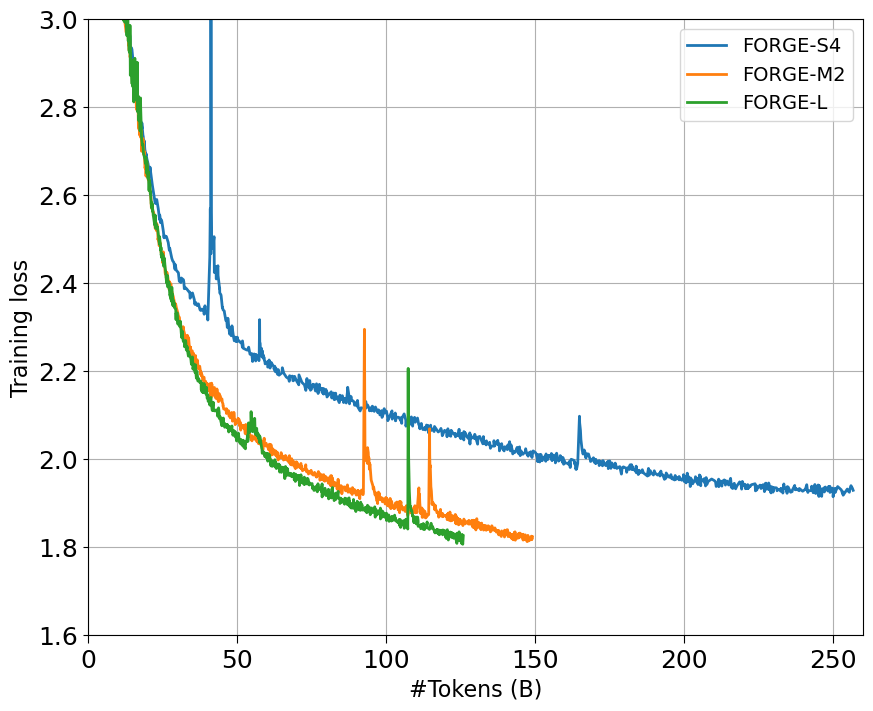

In [96]:
#full 


s4 = pd.read_csv("data/loss/s4.csv").iloc[:,1:]
m2 = pd.read_csv("data/loss/m2-ext.csv").iloc[:,1:]
l = pd.read_csv("data/loss/l-ext.csv").iloc[:,1:]


bs_s4 = 16777216
bs_m2  = 16515072
bs_l = 16777216

font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_ylim((1.6,3))
ax.set_xlim((0,260))

ax.plot(s4['Step']*bs_s4/10**9, s4['Value'],label='FORGE-S4')
ax.plot(m2['Step']*bs_m2/10**9, m2['Value'],label='FORGE-M2')
ax.plot(l['Step']*bs_l/10**9, l['Value'],label='FORGE-L')

ax.grid()
#ax.set_title("FORGE Domain",fontdict=font)
ax.set_ylabel('Training loss', fontdict=font)
ax.set_xlabel('#Tokens (B)', fontdict=font)

ax.legend()
fig.savefig('loss.png', dpi=300, bbox_inches='tight')

data/energy\log.gpu.24B-all-pp0.n128.1288769
12144
total energy:  48.90379021526419
TFLOPS/Watt:  0.2506878085734437


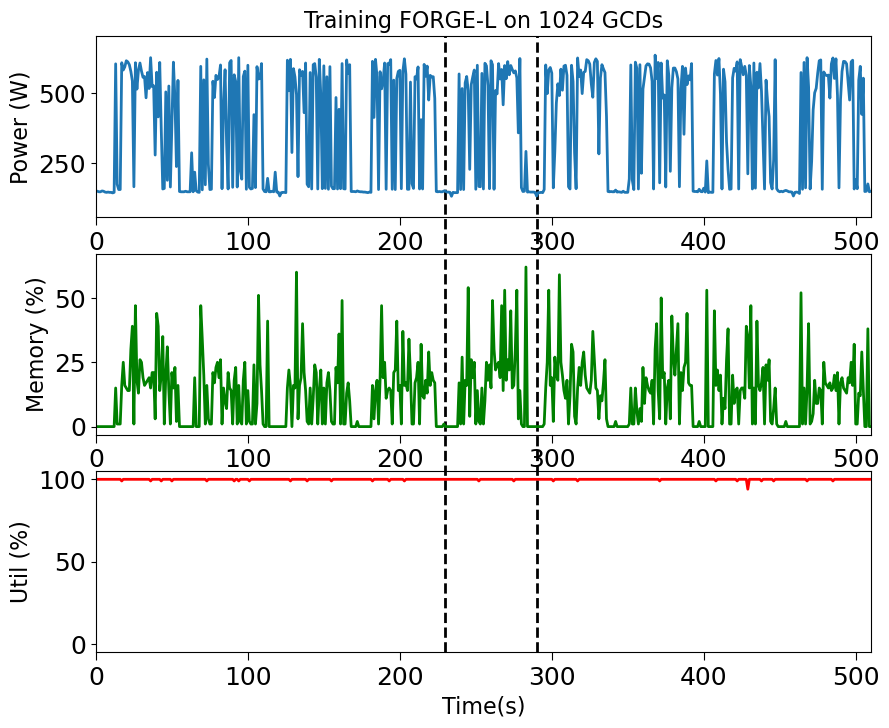

In [103]:
pwr, mem, util = read_stats(datadir="data/energy", sys='frontier', model="24B-all-pp0", gpuid=0)

print(max(pwr.keys()))
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, figsize=(10,8))
ax1.plot(np.array(list(pwr.keys()))-7010, pwr.values())
ax1.set_ylabel("Power (W)", fontdict=font)

ax2.plot(np.array(list(mem.keys()))-7010, mem.values(), color='g')
ax2.set_ylabel("Memory (%)", fontdict=font)

ax3.plot(np.array(list(util.keys()))-7010, util.values(), color='r')
ax3.set_ylabel("Util (%)", fontdict=font)
ax3.set_xlabel("Time(s)", fontdict=font)

x0 = 230; x1 = 290
ax1.axvline(x=x0,ymin=-1.2,ymax=1,c="black", linestyle="dashed", linewidth=2,zorder=0, clip_on=False)
ax2.axvline(x=x0,ymin=-1.2,ymax=1,c="black", linestyle="dashed", linewidth=2,zorder=0, clip_on=False)
ax3.axvline(x=x0,ymin=0,ymax=1,c="black", linestyle="dashed", linewidth=2,zorder=0, clip_on=False)

ax1.axvline(x=x1,ymin=-1.2,ymax=1,c="black", linestyle="dashed", linewidth=2,zorder=0, clip_on=False)
ax2.axvline(x=x1,ymin=-1.2,ymax=1,c="black", linestyle="dashed", linewidth=2,zorder=0, clip_on=False)
ax3.axvline(x=x1,ymin=0,ymax=1,c="black", linestyle="dashed", linewidth=2,zorder=0, clip_on=False)

ax1.set_xlim((0,510))
ax2.set_xlim((0,510))
ax3.set_xlim((0,510))
ax1.set_title("Training FORGE-L on 1024 GCDs", fontdict=font)

pavg, _ = measure(pwr, 7010, 7010+510)
tstep = 60 
print("total energy: ", pavg*1024/2*tstep*15300 / (3600*10**6))  #MWh
print("TFLOPS/Watt: ", 2*l_n64orion/pavg)
energy_L = pavg*(1024/2)*tstep*15300 / (3600*10**6)

fig.savefig('power1.png', dpi=300)